# Naive QG Implementation

In [1]:
import autoroot
import jax
import jax.numpy as jnp
import jax.scipy as jsp
from jax.config import config
import numpy as np
import numba as nb
import pandas as pd
import equinox as eqx
import finitediffx as fdx
import diffrax as dfx
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from einops import rearrange, repeat, reduce
from tqdm.notebook import tqdm, trange
from jaxtyping import Array, Float
import wandb
from jaxsw._src.models.qg import qg_r as qg

sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)
config.update("jax_enable_x64", True)


%matplotlib inline
%load_ext autoreload
%autoreload 2

## Equations

$$

$$

$$
\begin{aligned}
\partial_t q &= - \det\boldsymbol{J}(\psi,q) - \beta\partial_x\psi \\
q &= \nabla^2 \psi - \frac{1}{L_R^2}\psi \\
\psi &= \frac{f_0}{g}\eta \\
u &= -\partial_y\psi \\
v &= \partial_x\psi \\
f &= 2\Omega\sin\theta_0 + \frac{1}{R}2\Omega\cos\theta_0 y \\
f_0 &= \mathcal{E}[f] \\
L_R &= \frac{c_1}{f_0}
\end{aligned}
$$

where:
* $f_0=2\Omega\sin\theta_0$ is the Coriolis parameter at mean latitude $\bar{\theta}$
* $\beta=\frac{1}{R}2\Omega\cos\theta_0$ is the $\beta$-plane approximation at mean latitude
* $L_R$ is the Rossby deformation radius
* $\Omega$ is the angular frequency of rotation

Source:
* [Geophysical Fluid Dynamcis - Pedlosky](https://doi.org/10.1007/978-1-4612-4650-3)
* [Atmosphere and Oceanic Fluid Dynamics - Vallis](https://doi.org/10.1017/9781107588417)

## Read input SSH

In [2]:
ds = xr.open_dataset('/Users/eman/code_projects/data/scratch/NATL60_GULFSTREAM_degraded.nc')
ds = xr.open_dataset('/Users/eman/code_projects/data/scratch/NATL60-CJM165_GULFSTREAM_ssh_y2013.1y.nc', decode_times=False).assign_coords(time=lambda ds: pd.to_datetime(ds.time))
# ds = ds.coarsen(lon=3,lat=3).mean()
ds

<xarray.Dataset>
Dimensions:  (time: 365, lat: 201, lon: 201)
Coordinates:
  * lon      (lon) float64 -65.0 -64.95 -64.9 -64.85 ... -55.1 -55.05 -55.0
  * lat      (lat) float64 33.0 33.05 33.1 33.15 33.2 ... 42.85 42.9 42.95 43.0
  * time     (time) datetime64[ns] 2012-10-01 2012-10-02 ... 2013-09-30
Data variables:
    ssh      (time, lat, lon) float64 ...

In [3]:
lon = ds.lon.values
lat = ds.lat.values
ssh = ds.ssh[0].values.T


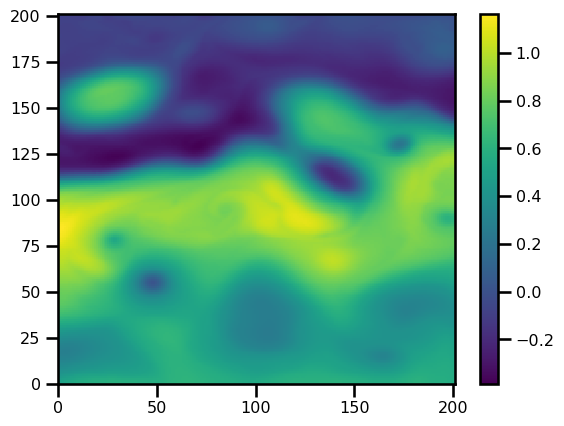

In [4]:
plt.figure()
plt.pcolormesh(ssh.T)
plt.colorbar()

In [5]:
def min_arrays(*args):
    arrays = [item for item in args]
    arrays = list(map(lambda x: x.min(), arrays))
    return np.min(np.stack([*arrays],axis=0))

def max_arrays(*args):
    arrays = [item for item in args]
    arrays = list(map(lambda x: x.max(), arrays))
    return np.max(np.stack([*arrays],axis=0))


## Looping

$$
\begin{aligned}
\psi^n &= f(\eta^n) \\
q^{n} &= f_2(\psi^n) \\
q^{n+1} &= q^{n} + \Delta t \hspace{1mm}\mathbf{rhs}(\psi, q) \\
\psi^{n+1} &= \text{Solve}(q^{n+1})
\end{aligned}
$$

In [6]:
from jaxopt.linear_solve import solve_cg

def pv_to_streamfn(q, dx, dy, c1=1.5, tol=1e-10, accuracy: int=1):
    
    def matvec_A(x):
        return qg.streamfn_to_pvort(x, dx, dy, c1=c1, accuracy=accuracy)
    
    psi = solve_cg(matvec=matvec_A, b=q, tol=tol)
    
    return psi

In [8]:
lon = ds.lon.values
lat = ds.lat.values
ssh = ds.ssh[0].values.T

dx, dy, f, beta = qg.lat_lon_deltas(lon, lat)
nx, ny = len(lon), len(lat)
dx = dy = jnp.mean(jnp.asarray([dx, dy]))
f0 = np.asarray(np.mean(f))
dt = 600 # 10 mins / 600 s
c1 = 2.7 #25_000 #1.5
g = 9.91
tol = 1e-15
upwind = False
beta = False

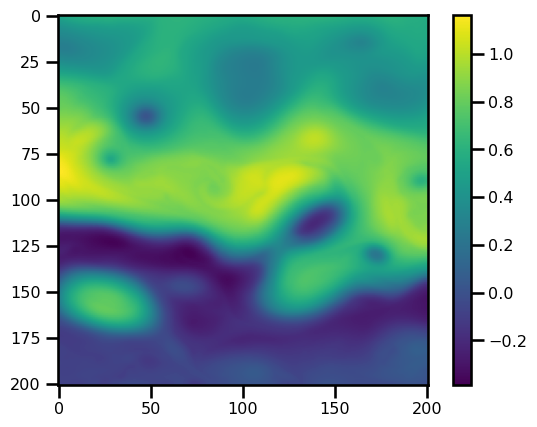

In [9]:
pts = plt.imshow(ssh.T)
plt.colorbar(pts)

In [10]:
# calculate stream function
psi = qg.ssh_to_streamfn(ssh=ssh, f0=f0)

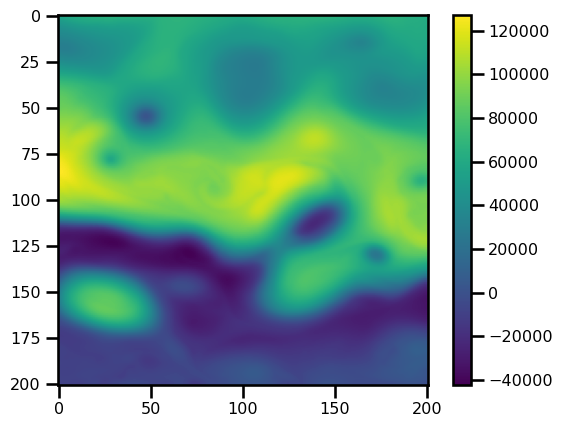

In [11]:
pts = plt.imshow(psi.T)
plt.colorbar(pts)

In [12]:

# calculate potential vorticity
q = qg.streamfn_to_pvort(psi=psi, dx=dx, dy=dy, c1=c1)


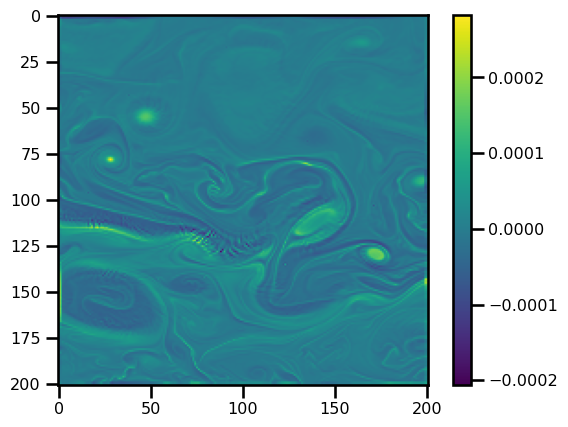

In [13]:
pts = plt.imshow(q.T)
plt.colorbar(pts)

In [15]:
# calculate RHS (advection, beta terms)
rhs = qg.rhs_fn(q=q, psi=psi, dx=dx, dy=dy, f0=f0, way=1, upwind=False, beta=False)

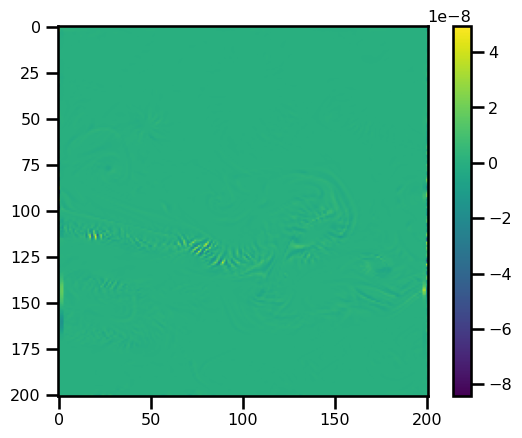

In [16]:
pts = plt.imshow(rhs.T)
plt.colorbar(pts)

In [17]:
# time step (Euler)
qnew = q + dt * rhs

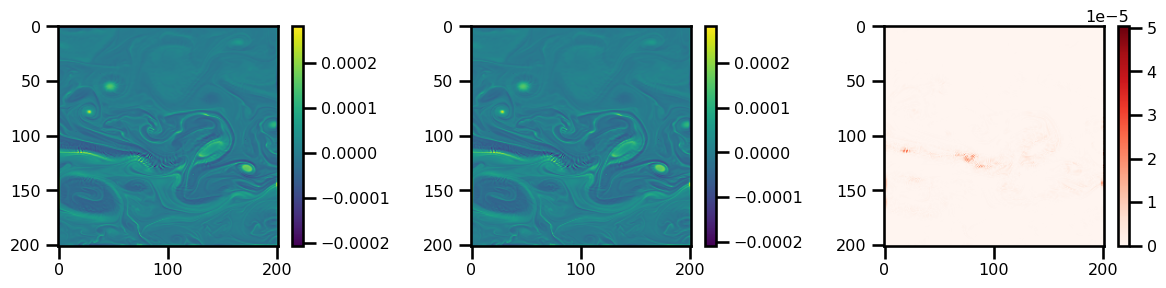

In [18]:
fig, ax = plt.subplots(ncols=3, figsize=(12,3))

pts = ax[0].imshow(q.T, cmap="viridis")
plt.colorbar(pts)

pts = ax[1].imshow(qnew.T, cmap="viridis")
plt.colorbar(pts)

pts = ax[2].imshow(jnp.abs(q.T - qnew.T), cmap="Reds")
plt.colorbar(pts)


plt.tight_layout()
plt.show()


In [100]:
from jaxsw._src.utils.dst_solver import inverse_elliptical_dst_solver
from jaxsw._src.utils.linear_solver import conjugate_gradient

def pv_to_streamfn(q: Array, psi_bc,dx, dy, tol:float=1e-5, maxiters: int=100, accuracy: int=1) -> Array:
    
    # parse state, constants, steps

    
    # define matrix multiplcation term
    def matvec_Lp(psi):
        # psi = enforce_boundaries_psi(psi, psi_bc)
        q = qg.streamfn_to_pvort(psi, dx, dy, c1=c1, accuracy=accuracy)
        return q
    
    pnew = conjugate_gradient(
        q, 
        matvec_fn=matvec_Lp, 
        # u_init=p,
        target_criterion=tol,
        max_iterations=maxiters
    ).u
    # pnew = linear_solve.solve_cg(matvec=matvec_Lp, b=q, tol=1e-5)
    
    return pnew

def enforce_boundaries_psi(u, u_bc):
    u = u.at[0,:].set(u_bc[0,:])
    u = u.at[-1,:].set(u_bc[-1,:])
    u = u.at[:,0].set(u_bc[:,0])
    u = u.at[:,-1].set(u_bc[:,-1])
    return u

In [20]:
# from jaxopt.linear_solve import solve_cg

# def pv_to_streamfn(q, dx, dy, c1=1.5, tol=1e-10, accuracy: int=1):
    
#     def matvec_A(x):
#         return qg.streamfn_to_pvort(x, dx, dy, c1=c1, accuracy=accuracy)
    
#     psi = solve_cg(matvec=matvec_A, b=q, tol=tol)
    
#     return psi

In [23]:
# # calculate stream function
# tol = 1e-10
# maxiters = 10_000
# out = pv_to_streamfn(q=q, psi_bc=psi, dx=dx, dy=dy, tol=tol, maxiters=maxiters)
# # psi_new = pv_to_streamfn(q=qnew, dx=dx, dy=dy, tol=tol, maxiters=maxiters)

In [24]:
# fig, ax = plt.subplots(ncols=3, figsize=(12,3))

# pts = ax[0].imshow(psi.T, cmap="viridis")
# plt.colorbar(pts)

# pts = ax[1].imshow(out.T, cmap="viridis")
# plt.colorbar(pts)

# pts = ax[2].imshow(jnp.abs(psi.T - out.T), cmap="Reds")
# plt.colorbar(pts)


# plt.tight_layout()
# plt.show()


In [25]:
# ssh_new = qg.streamfn_to_ssh(psi=out, f0=f0)

In [27]:
# fig, ax = plt.subplots(ncols=3, figsize=(12,3))

# pts = ax[0].imshow(ssh.T, cmap="viridis")
# plt.colorbar(pts)

# pts = ax[1].imshow(ssh_new.T, cmap="viridis")
# plt.colorbar(pts)

# pts = ax[2].imshow(jnp.abs(ssh.T - ssh_new.T), cmap="Reds")
# plt.colorbar(pts)


# plt.tight_layout()
# plt.show()

In [28]:

# # calculate RHS (advection, beta terms)
# rhs = qg.rhs_fn(q=q, psi=psi, dx=dx, dy=dy, f0=f0, way=way, upwind=upwind, beta=beta)

# # time step (Euler)
# q = q + dt * rhs

# # calculate stream function
# psi = pv_to_streamfn(q=q, dx=dx, dy=dy, tol=tol, c1=c1)

# # calculate ssh
# ssh = qg.streamfn_to_ssh(psi=psi, f0=f0)
# # print(ssh.min(), ssh.max())

In [29]:
from tqdm.autonotebook import trange

lon = ds.lon.values
lat = ds.lat.values
ssh = ds.ssh[0].values.T

dx, dy, f = qg.lat_lon_deltas(lon, lat)
f0 = jnp.mean(f)
dt = 600 # 10 mins / 600 s
c1 = 25_000 #1.5
way = 1
tol = 1e-10
maxiters = 10_000
n_iterations = 10
upwind = False
beta = False


/var/folders/k9/_v6ywhvj0nq36tpttd3j4mq80000gn/T/ipykernel_86082/3553997505.py:1: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import trange


In [14]:
from jaxsw._src.utils.dst_solver import inverse_elliptical_dst_solver

def enforce_boundaries_helmholtz(u, u_bc, kappa):
    u = u.at[0,:].set(-kappa * u_bc[0,:])
    u = u.at[-1,:].set(-kappa * u_bc[-1,:])
    u = u.at[:,0].set(-kappa * u_bc[:,0])
    u = u.at[:,-1].set(-kappa * u_bc[:,-1])
    return u

def calculate_psi_to_pv(psi, psi_bcs, dx, dy, f0, c1, accuracy:int=1):
    # calculate potential vorticity
    kappa = (f0/c1)**2
    q = qg.streamfn_to_pvort(psi, dx, dy, f0=f0, c1=c1,accuracy=1)
    q = enforce_boundaries_helmholtz(q, psi_bcs, kappa=kappa)
    return q

def set_interior_zero(psi):
    psi = psi.at[1:-1,1:-1].set(0.0)
    return psi

def calculate_pv_to_psi(q, psi, dx, dy, f0, c1, accuracy: int=1):
    
    # calculate interior potential vorticity
    psi_bv = set_interior_zero(psi)
    q_bv = qg.streamfn_to_pvort(psi_bv, dx, dy, f0=f0, c1=c1,accuracy=1)
    q_bv = enforce_boundaries_helmholtz(q_bv, psi_bv, kappa=(f0/c1)**2)
    
    # remove interior
    q_in = q[1:-1,1:-1] - q_bv[1:-1,1:-1]
    
    # do the inversion
    inv = inverse_elliptical_dst_solver(
        q_in, nx, ny, dx, dy, kappa=(f0/c1)**2
    )
    # psi = jnp.zeros_like(q)
    # psi = psi.at[1:-1,1:-1].set(inv)
    # psi += psi_bv
    psi = psi.at[1:-1,1:-1].set(inv)
    
    return psi

In [15]:
from jaxsw._src.operators.functional.fd import jacobian

In [17]:
from tqdm.autonotebook import trange

lon = ds.lon.values
lat = ds.lat.values
ssh = jnp.asarray(ds.ssh[0].values.T)

dx, dy, f, beta = qg.lat_lon_deltas(lon, lat)
nx, ny = len(lon), len(lat)
dx0 = dy0 = jnp.mean(jnp.asarray([dx, dy]))
f0 = np.asarray(np.mean(f))
beta0 = jnp.mean(beta)
dt = 600 # 10 mins / 600 s
c1 = 1.5 #25_000 #1.5
g = 9.91
tol = 1e-15
maxiters = 10_000
n_days = 1
n_iterations = int(144 * n_days) #143*20
upwind = True
beta = False
debug = False
bc = "periodic" #"dirichlet"
way = 1


def step(ssh, q):
    
    # calculate stream function
    psi_bv = qg.ssh_to_streamfn(ssh=ssh, f0=f0)
    
    # psi = pv_to_streamfn(q, psi_bv, dx=dx, dy=dy, tol=tol, maxiters=maxiters, accuracy=1)
    
    # potential vorticity -> stream function
    psi = calculate_pv_to_psi(q, psi_bv, dx=dx, dy=dx, f0=f0, c1=c1, accuracy=1) 
    
    # # upwind scheme for advection
    # rhs = -jacobian(
    #     p=psi, q=q, dx=dx, dy=dy, bc=bc, pad=True
    # )
    
    # upwind scheme for advection
    rhs = -qg.advection_term_upwind(
        q, psi, dx=dx, dy=dx, way=way
    )
    
    # beta term
    _, v = qg.streamfn_to_velocity(psi, dx=dx, dy=dy)
    rhs += - beta0 * v
    
    # time step (Euler)
    q = q + dt * rhs
    
#     # potential vorticity -> stream function

    psi = calculate_pv_to_psi(q, psi, dx=dx, dy=dx, f0=f0, c1=c1, accuracy=1) 
    
#     # stream function to ssh
    ssh = ssh.at[1:-1,1:-1].set(qg.streamfn_to_ssh(psi, f0=f0)[1:-1,1:-1])
    # ssh = qg.streamfn_to_ssh(psi, f0=f0)
                               
    return ssh, q

if not debug:
    step = jax.jit(step)

# do initial step
psi = qg.ssh_to_streamfn(ssh=ssh, f0=f0)
q = qg.streamfn_to_pvort(psi, dx, dy, f0=f0, c1=c1,accuracy=1)
q = enforce_boundaries_helmholtz(q, psi, kappa=(f0/c1)**2)

for iteration in trange(n_iterations):
    
    ssh, q = step(ssh, q)
    
q.min(), q.max()

  0%|          | 0/144 [00:00<?, ?it/s]

(Array(-0.00046273, dtype=float64), Array(0.00018376, dtype=float64))

In [19]:
psi = calculate_pv_to_psi(q, psi, dx=dx, dy=dx, f0=f0, c1=c1, accuracy=1) 
ssh = qg.streamfn_to_ssh(psi, f0=f0)

ssh.min(), ssh.max(), q.min(), q.max()

(Array(-0.34245846, dtype=float64),
 Array(1.16310116, dtype=float64),
 Array(-0.00046273, dtype=float64),
 Array(0.00018376, dtype=float64))

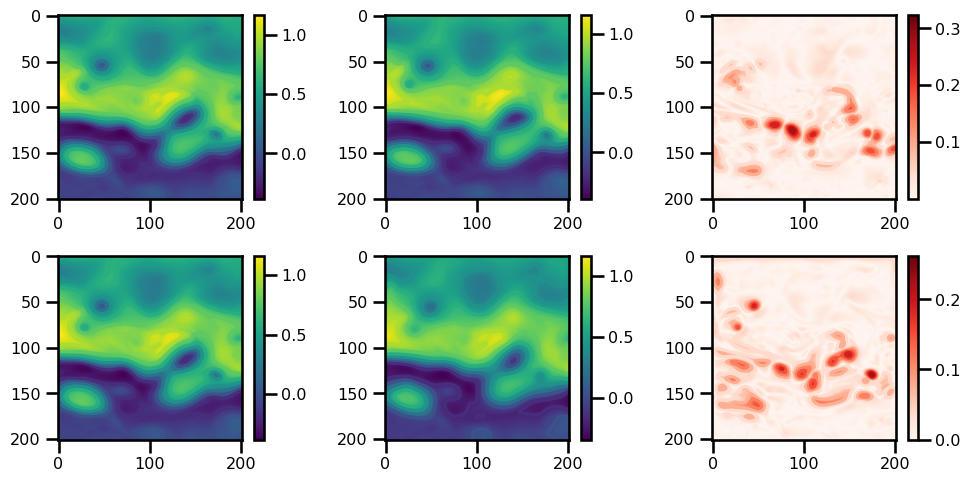

In [20]:
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(10,5))

# 
ax[0,0].contour(ds.ssh[0].values, cmap="viridis")
pts = ax[0,0].imshow(ds.ssh[0].values, cmap="viridis")
plt.colorbar(pts)
ax[0,1].contour(ds.ssh[1].values, cmap="viridis")
pts = ax[0,1].imshow(ds.ssh[1].values, cmap="viridis")
plt.colorbar(pts)
ax[0,2].contour(
    np.abs(ds.ssh[0].values - ds.ssh[1].values), 
    cmap="Reds")
pts = ax[0,2].imshow(
    np.abs(ds.ssh[0].values - ds.ssh[1].values), 
    cmap="Reds"
)
plt.colorbar(pts)


ax[1,0].contour(ds.ssh[0].values, cmap="viridis")
pts = ax[1,0].imshow(ds.ssh[0].values, cmap="viridis")
plt.colorbar(pts)
ax[1,1].contour(ssh.T, cmap="viridis")
pts = ax[1,1].imshow(ssh.T, cmap="viridis")
plt.colorbar(pts)
ax[1,2].contour(
    np.abs(ds.ssh[0].values - ssh.T), 
    cmap="Reds")
pts = ax[1,2].imshow(
    np.abs(ds.ssh[0].values - ssh.T), 
    cmap="Reds"
)
plt.colorbar(pts)
plt.tight_layout()
plt.show()



In [33]:
from tqdm.autonotebook import trange


In [37]:
from tqdm.autonotebook import trange
from jaxsw._src.operators.functional.fd import jacobian

lon = ds.lon.values
lat = ds.lat.values
ssh = jnp.asarray(ds.ssh[0].values.T)

dx, dy, f, beta = qg.lat_lon_deltas(lon, lat)
nx, ny = len(lon), len(lat)
dx0 = dy0 = jnp.mean(jnp.asarray([dx, dy]))
f0 = jnp.asarray(np.mean(f))
beta0 = jnp.mean(beta)
dt = 600 # 10 mins / 600 s
c1 = 1.5 #25_000 #1.5
g = 9.91
tol = 1e-15
maxiters = 10_000
n_days = 10
n_iterations = 144 * n_days #143*20
upwind = True
beta = False
debug = False
way = 1
bc = "periodic"


def step(ssh, q):
    
    # calculate stream function
    psi_bv = qg.ssh_to_streamfn(ssh=ssh, f0=f0)
        
    # potential vorticity -> stream function
    psi = calculate_pv_to_psi(q, psi_bv, dx=dx, dy=dx, f0=f0, c1=c1, accuracy=1) 
    
    # calculate SSH
    # ssh = ssh.at[1:-1,1:-1].set(qg.streamfn_to_ssh(psi, f0=f0)[1:-1,1:-1])
    # ssh = qg.streamfn_to_ssh(psi, f0=f0)
        
    # # upwind scheme for advection
    # rhs = -jacobian(
    #     p=psi, q=q, dx=dx, dy=dy, bc=bc, pad=True
    # )

    # upwind scheme for advection
    rhs = -qg.advection_term_upwind(
        q, psi, dx=dx, dy=dx, way=way
    )
    
    # beta term
    _, v = qg.streamfn_to_velocity(psi, dx=dx, dy=dy)
    rhs += - beta0 * v
    
    # time step (Euler)
    q = q + dt * rhs
                               
    return ssh, q

if not debug:
    step = jax.jit(step)


# do initial step
psi = qg.ssh_to_streamfn(ssh=ssh, f0=f0)
q = qg.streamfn_to_pvort(psi, dx, dy, f0=f0, c1=c1,accuracy=1)
q = enforce_boundaries_helmholtz(q, psi, kappa=(f0/c1)**2)

for iteration in trange(n_iterations):
    
    ssh, q = step(ssh, q)
    
q.min(), q.max()

  0%|          | 0/1440 [00:00<?, ?it/s]

(Array(-0.0005632, dtype=float64), Array(0.00017895, dtype=float64))

In [38]:
psi = calculate_pv_to_psi(q, psi, dx=dx, dy=dx, f0=f0, c1=c1, accuracy=1) 
ssh = qg.streamfn_to_ssh(psi, f0=f0)

ssh.min(), ssh.max(), q.min(), q.max()

(Array(-0.31712565, dtype=float64),
 Array(1.16310116, dtype=float64),
 Array(-0.0005632, dtype=float64),
 Array(0.00017895, dtype=float64))

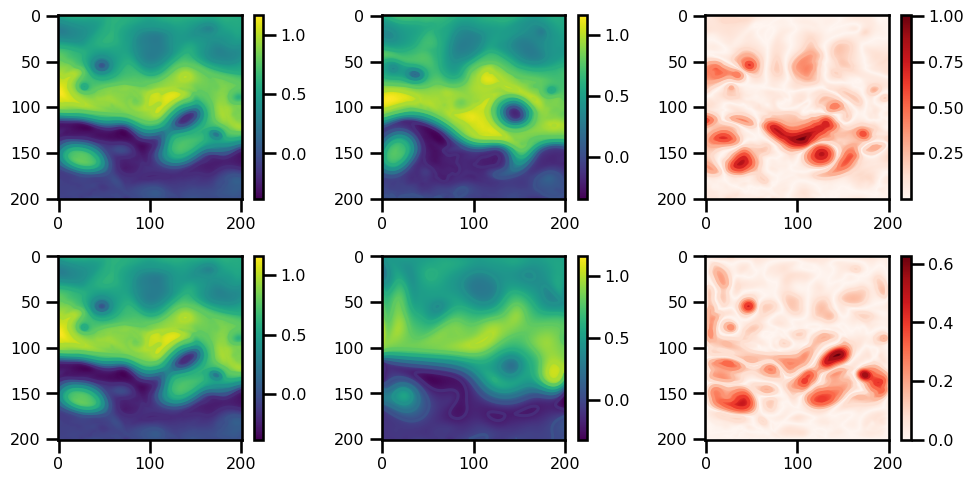

In [39]:
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(10,5))

# 
ax[0,0].contour(ds.ssh[0].values, cmap="viridis")
pts = ax[0,0].imshow(ds.ssh[0].values, cmap="viridis")
plt.colorbar(pts)
ax[0,1].contour(ds.ssh[n_days].values, cmap="viridis")
pts = ax[0,1].imshow(ds.ssh[n_days].values, cmap="viridis")
plt.colorbar(pts)
ax[0,2].contour(
    np.abs(ds.ssh[0].values - ds.ssh[n_days].values), 
    cmap="Reds")
pts = ax[0,2].imshow(
    np.abs(ds.ssh[0].values - ds.ssh[n_days].values), 
    cmap="Reds"
)
plt.colorbar(pts)


ax[1,0].contour(ds.ssh[0].values, cmap="viridis")
pts = ax[1,0].imshow(ds.ssh[0].values, cmap="viridis")
plt.colorbar(pts)
ax[1,1].contour(ssh.T, cmap="viridis")
pts = ax[1,1].imshow(ssh.T, cmap="viridis")
plt.colorbar(pts)
ax[1,2].contour(
    np.abs(ds.ssh[0].values - ssh.T), 
    cmap="Reds")
pts = ax[1,2].imshow(
    np.abs(ds.ssh[0].values - ssh.T), 
    cmap="Reds"
)
plt.colorbar(pts)
plt.tight_layout()
plt.show()

